In [74]:
import requests
import os
import json
import pandas as pd
import datetime
import re
import string
import seaborn as sns
sns.set_style("dark")

# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = os.environ.get("BEARER_TOKEN")
bearer_token ='AAAAAAAAAAAAAAAAAAAAACqHUgEAAAAAcghJSkKBmFmw36ZiRxrqVdyomIk%3DZlDqMjNA0ka4btIuhDjiHUyRGoCHDzKBWvNGcqYXpLJ5kuhUAp'

In [75]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# 1. Collecting data: 
In this assignment you need to collect data related to stock market from Twitter for one week. In Twitter, ticker symbols like #gold are used for stocks and companies. You are requested to collect the tweets with some specific keywords and store them in different files. The following keywords should be used:  
* Altcoin  
* Bitcoin  
* Coindesk  
* Cryptocurrency  
* Gold  
* APPL  
* GOOG  
* YHOO

Each tweet is a json file with the following format:  
```
{"created_at":”..........”,  
"id":”...........”,  
"text":" Time to buy some ether!\n#ethereum #investing #cryptocurrency”  
“user_id”:”...........”  
...  
}
```

In [76]:
dates = [
    # datetime.datetime(2021,10,16, 1),
    datetime.datetime(2021,10,17),
    datetime.datetime(2021,10,18),
    datetime.datetime(2021,10,19),
    datetime.datetime(2021,10,20),
    datetime.datetime(2021,10,21),
    datetime.datetime(2021,10,22),
]
keywords = ['altcoin', 'bitcoin', 'coindesk', 'cryptocurrency', 'gold', 'APPL', 'GOOG', 'YHOO']

In [91]:
class Scrapper:
    def __init__(self, keyword):
        self.keyword = keyword
        # Creates the dataframe for the keyword
        self.dataframe = pd.DataFrame()
    
    def file_name(self):
        return f'data/tweets_{self.keyword}.csv'

    def check_file_existence(self):
        return os.path.exists(self.file_name())
    
    def get_tweets(self, from_date):
        from_date_time = datetime.datetime(from_date.year, from_date.month, from_date.day, 10)
        to_date = datetime.datetime(from_date.year, from_date.month, from_date.day, 16)
        search_url = "https://api.twitter.com/2/tweets/search/recent"
        next_token = None
        # Tries to get 8 batches of 100 records
        for i in range(8):
            query_params = {
                'query': self.keyword, 
                'start_time': from_date_time.isoformat("T") + "Z", 
                'end_time': to_date.isoformat("T") + "Z",
                'tweet.fields': 'author_id,created_at', 
                'user.fields': 'location',
                'expansions': 'geo.place_id',
                'place.fields': 'country',
                'max_results': 100,
                'next_token': next_token
            }
            print(f'Querying keyword: "{self.keyword}", date: "{from_date}", asking for a batch of 100 tweets from API...')
            # Queries Twitter to get the keyword related tweets
            json_response = connect_to_endpoint(search_url, query_params)
            # Convert the response to a dataframe
            df = pd.DataFrame(json_response['data']) 
            df['Keyword'] = self.keyword
            # Appends the results to the planned day dataframe
            self.dataframe = self.dataframe.append(df, ignore_index=True)
            next_token = json_response['meta'].get('next_token', None)
            if next_token == None:
                break
       
    def save(self):
        print(f'Saving {self.file_name()}')
        self.dataframe.to_csv(self.file_name())
        
    def load(self):
        print(f'Loading {self.file_name()}')
        self.dataframe = pd.read_csv(self.file_name())
    

# 2. Saving data: 
You need to save the requested data into csv format of 8 files where data related to each keyword is saved. Each file consist of four columns: 
* tweet id
* time of tweet
* user id
* text.

In [92]:
# Executes the planned queries for each keyword
for keyword in keywords:
    scrapper = Scrapper(keyword)
    if scrapper.check_file_existence():
        # If the file already exists ommits the query to twitter API
        print(f'File {scrapper.file_name()} already exists.. skipping query to twitter API')
        continue
    # Gets tweet for each date
    for date in dates:
        scrapper.get_tweets(date)
    # Saves the file
    scrapper.save()       
        

Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-18 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2

# 3. Cleaning data: 
remove duplication, remove punctuations, remove numbers in tweets, and remove words with length less than 2.

In [93]:
# Reads the tweets csv files and consolidates them in a single dataframe
complete_df = pd.DataFrame() 
for keyword in keywords:
    scrapper = Scrapper(keyword)
    # Loads the data from its corresponding CSV file
    scrapper.load()
    # Merges the data in a single dataframe
    complete_df = complete_df.append(scrapper.dataframe, ignore_index=True)

Loading data/tweets_altcoin.csv
Loading data/tweets_bitcoin.csv
Loading data/tweets_coindesk.csv
Loading data/tweets_cryptocurrency.csv
Loading data/tweets_gold.csv
Loading data/tweets_APPL.csv
Loading data/tweets_GOOG.csv
Loading data/tweets_YHOO.csv


In [94]:
complete_df.head(10)

,Unnamed: 0,id,created_at,author_id,text,Keyword,geo
0,0,1449767153914109962,2021-10-17T15:59:59.000Z,1259003447535218689,RT @proton_theGreat: Q4 is here and getting re...,altcoin,NaN
1,1,1449767145231945739,2021-10-17T15:59:57.000Z,1279802920842620929,RT @proton_theGreat: Q4 is here and getting re...,altcoin,NaN
2,2,1449767140593000453,2021-10-17T15:59:56.000Z,1188849354137690115,RT @proton_theGreat: Q4 is here and getting re...,altcoin,NaN
3,3,1449767139217268738,2021-10-17T15:59:56.000Z,1400030874238734336,RT @CryptoZoroo: Stark wie ein Drache 🐉 ist d...,altcoin,NaN
4,4,1449767134129754112,2021-10-17T15:59:54.000Z,1398671816000950277,RT @yusufalemdars: @kerimcalender Bitcoin’in i...,altcoin,NaN
5,5,1449767132883943429,2021-10-17T15:59:54.000Z,800518296,RT @proton_theGreat: Q4 is here and getting re...,altcoin,NaN
6,6,1449767111467831303,2021-10-17T15:59:49.000Z,1282872415165403136,RT @proton_theGreat: Q4 is here and getting re...,altcoin,NaN
7,7,1449767106510090242,2021-10-17T15:59:48.000Z,1442662031094534147,RT @B055Lady_Elle: $poodl\n\nIf you don't got ...,altcoin,NaN
8,8,1449767091343613959,2021-10-17T15:59:44.000Z,195718295,Aqarchain is the flagship product of the Smart...,altcoin,NaN
9,9,1449767080882950146,2021-10-17T15:59:42.000Z,1394133178562977795,RT @proton_theGreat: Q4 is here and getting re...,altcoin,NaN


In [95]:
def clean_data(text):
    # Remove numbers
    text = re.sub(r'[0-9]+', '', text)
    # remove all words with a length less than 2
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # remove all citations to twitter users
    text = re.sub(r'\@\w+\b', '', text)
    # Remove punctuation
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return text

def clean(dataframe_to_clean):
    dataframe_to_clean['text'] = dataframe_to_clean['text'].apply(lambda x: clean_data(x)) 
    return dataframe_to_clean

In [96]:
clean_df = clean(complete_df)

In [97]:
clean_df.head(10)

,Unnamed: 0,id,created_at,author_id,text,Keyword,geo
0,0,1449767153914109962,2021-10-17T15:59:59.000Z,1259003447535218689,here and getting ready for the altcoin par...,altcoin,NaN
1,1,1449767145231945739,2021-10-17T15:59:57.000Z,1279802920842620929,here and getting ready for the altcoin par...,altcoin,NaN
2,2,1449767140593000453,2021-10-17T15:59:56.000Z,1188849354137690115,here and getting ready for the altcoin par...,altcoin,NaN
3,3,1449767139217268738,2021-10-17T15:59:56.000Z,1400030874238734336,stark wie ein drache 🐉 ist das mxsamurai te...,altcoin,NaN
4,4,1449767134129754112,2021-10-17T15:59:54.000Z,1398671816000950277,bitcoin’ işi daha bitmedi bence bir fomo ol...,altcoin,NaN
5,5,1449767132883943429,2021-10-17T15:59:54.000Z,800518296,here and getting ready for the altcoin par...,altcoin,NaN
6,6,1449767111467831303,2021-10-17T15:59:49.000Z,1282872415165403136,here and getting ready for the altcoin par...,altcoin,NaN
7,7,1449767106510090242,2021-10-17T15:59:48.000Z,1442662031094534147,poodl\n\n you don got get you have hodl ...,altcoin,NaN
8,8,1449767091343613959,2021-10-17T15:59:44.000Z,195718295,aqarchain the flagship product the smart cha...,altcoin,NaN
9,9,1449767080882950146,2021-10-17T15:59:42.000Z,1394133178562977795,here and getting ready for the altcoin par...,altcoin,NaN


# 4. Visualizing data: 
You need to present the daily number of tweets for each keyword as well as the daily number of users.  

In [98]:
# Adds a column with the date part of the creation date.
clean_df['created_date'] = pd.to_datetime(clean_df['created_at']).apply(lambda d: d.date())

In [99]:
def get_pivot(df, field):
    return pd.pivot_table(clean_df,
                          values= field, 
                          columns = ['Keyword'], 
                          index= ['created_date'],
                          aggfunc = lambda x: len(x.unique()))

def visualize_bars(pivot_df, custom_title):
    plot = pivot_df.plot.bar(title=custom_title, figsize=(17,5)).legend(
        loc='upper center', ncol=4, title="Keywords")
    return plot
    

In [100]:
table_per_tweets = get_pivot(clean_df, 'id')
table_per_users = get_pivot(clean_df, 'author_id')

In [101]:
# This table contains the summary by amount of tweets per day and keyword
table_per_tweets

Keyword,APPL,GOOG,YHOO,altcoin,bitcoin,coindesk,cryptocurrency,gold
created_date,,,,,,,,
2021-10-17,69,353,483,693,784,800,798,779
2021-10-18,114,451,799,792,789,798,799,796
2021-10-19,152,391,601,797,799,800,799,796
2021-10-20,162,641,568,795,796,800,798,796
2021-10-21,161,522,730,798,800,799,800,796
2021-10-22,96,799,800,799,796,800,800,798


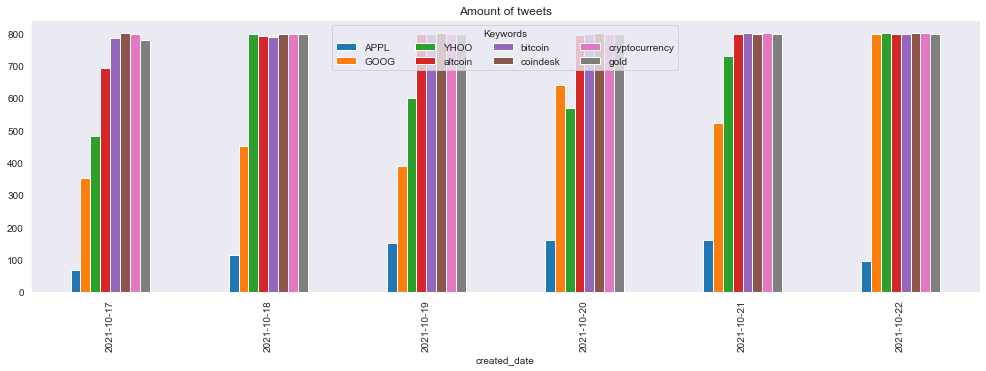

In [102]:
visualize_bars(table_per_tweets, 'Amount of tweets')

In [103]:
# This table contains the summary by amount of users per day and keyword
table_per_users

Keyword,APPL,GOOG,YHOO,altcoin,bitcoin,coindesk,cryptocurrency,gold
created_date,,,,,,,,
2021-10-17,52,284,402,511,634,509,611,742
2021-10-18,94,369,700,427,670,606,629,723
2021-10-19,115,311,489,656,675,690,564,757
2021-10-20,126,554,484,527,701,624,608,735
2021-10-21,124,428,593,478,702,672,595,715
2021-10-22,68,610,686,613,671,608,587,719


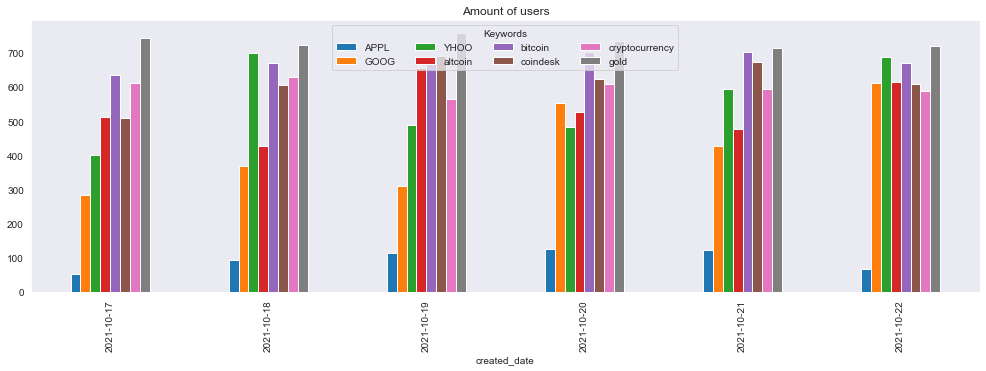

In [104]:
visualize_bars(table_per_users, 'Amount of users')